# Imports

In [5]:
import re
import os
import random
from datetime import datetime

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import numpy as np
import torch
from transformers import T5Tokenizer

from evaluation import Evaluator
from visualization import plot_graphs
from data_utils.dataset import prepare_data
from data_utils.utils import read_json
from models.rec_ace import RecACEWrapModel, detokenize_and_clean

## Seeds

In [6]:
SEED = 42

# Set the random seed for Python
random.seed(SEED)

# Set the random seed for numpy
np.random.seed(SEED)

torch.manual_seed(SEED)

# Data Paths

In [7]:
datasets_dict = {
    # Default
    'Default Train Clean': 'data/default/train_clean.json',
    'Default Train Other': 'data/default/train_other.json',
    'Default Dev Clean': 'data/default/dev_clean.json',
    'Default Dev Other': 'data/default/dev_other.json',
    'Default Test Clean': 'data/default/test_clean.json',
    'Default Test Other': 'data/default/test_other.json',
    # Video
    'Video Train Clean': 'data/video/train_clean.json',
    'Video Train Other': 'data/video/train_other.json',
    'Video Dev Clean': 'data/video/dev_clean.json',
    'Video Dev Other': 'data/video/dev_other.json',
    'Video Test Clean': 'data/video/test_clean.json',
    'Video Test Other': 'data/video/test_other.json', 
}

# Load essentials

In [8]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
DEVICE

'cuda'

In [10]:
debug = True

# Base architecture
t5_type = 't5-small'

# How to quantize the confidence vectors [only required for rec_ac]
bin_size=10

### Tokenizer

In [11]:
tokenizer = T5Tokenizer.from_pretrained("t5-small")

## Read Data

In [12]:
train_set = read_json(json_path=datasets_dict['Default Train Clean'])
dev_set = read_json(json_path=datasets_dict['Default Dev Clean'])

## Prepare as DataLoader

In [13]:
batch_size = 64
train_loader = prepare_data(data=train_set, tokenizer=tokenizer, batch_size=batch_size, shuffle=True, debug=debug)
dev_loader = prepare_data(data=dev_set, tokenizer=tokenizer, batch_size=batch_size, shuffle=False)

Debug Mode - using only 10390 out of 103895, training datapoints
- Converting the input sentences into tokens
- Converting the GT sentences into tokens
- Converting the input sentences into tokens
- Converting the GT sentences into tokens


# Evaluating metrics for the ASR

In [14]:
types = ['train', 'dev']
asr_evaluator = Evaluator(metrics=['wer', 'em', 'bleu', 'gleu'], set_types=types)

for set_type, loader in zip(types, [train_loader, dev_loader]):
    for batch in loader:
        reference = detokenize_and_clean(tokenizer, batch['sentences'])
        predicted = detokenize_and_clean(tokenizer, batch['labels'])
        asr_evaluator.calculate_metrics(set_type=set_type, reference=reference, predicted=predicted)

asr_evaluator.end_epoch_routine(print_metrics=False)

# Print final metrics
asr_evaluator.print_final_metrics()

# Save results to disk
dir_path = os.path.join('results', 'ASR')
os.makedirs(dir_path, exist_ok=True)
asr_evaluator.store_df(dir_path)

Train Metrics:
+----+-------+-------+--------+--------+
|    |   wer |    em |   bleu |   gleu |
|----+-------+-------+--------+--------|
|  1 | 0.127 | 0.120 |  0.772 |  0.785 |
+----+-------+-------+--------+--------+

Dev Metrics:
+----+-------+-------+--------+--------+
|    |   wer |    em |   bleu |   gleu |
|----+-------+-------+--------+--------|
|  1 | 0.132 | 0.307 |  0.754 |  0.795 |
+----+-------+-------+--------+--------+



# Training

In [15]:
def training(model, n_epochs, train_data, dev_data, optimizer, exp_name, save_model=True):
    """ Training loop for the model

        Args:
            model (nn.Module): Model to train
            n_epochs (int): Number of epochs to train
            train_data (DataLoader): DataLoader with train data
            dev_data (DataLoader): DataLoader with dev data
            optimizer (torch.optim): Optimizer for the model
            exp_name (str): Name of the experiment
            save_model (bool): Whether to save the model after training

        Returns:
            dict: Dictionary with train and dev losses and accuracies
    """

    assert exp_name, "Must supply experiment name"
    assert model.model_type in ['original', 'rec_ace'], f"{model.model_type} is not a valid training scheme"

    print(f"Experiment name: {exp_name}")
    print(f"Training model of type: {model.model_type}")
    print(f"Confidence vectors are {'NOT IN USED' if model.model_type == 'original' else 'IN USED'}")

    if save_model:
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        output_dir = f'./results/{exp_name}/{timestamp}'
        os.makedirs(output_dir, exist_ok=True)
        print(f"Saving model to: {output_dir}")

    # Initialize metrics evaluator
    evaluator = Evaluator(metrics=['wer', 'em'], set_types=['train', 'dev'])
    train_epoch_losses, dev_epoch_losses = [], []

    # Training loop
    pbar = tqdm(range(n_epochs), position=0, leave=False)
    for epoch in pbar:
        pbar.set_description(f"Epoch: {epoch+1}/{n_epochs}")

        train_losses, dev_losses = [], []

        ### TRAIN
        model.train()

        # Iterating over batches in train data
        pbar_train = tqdm(train_data, desc="Train", leave=False)
        for batch in pbar_train:

            optimizer.zero_grad()

            X = batch['sentences'].to(DEVICE)
            S = batch['scores'].to(DEVICE)
            y = batch['labels'].to(DEVICE)

            preds = model(input_ids=X, labels=y, scores_ids=S)

            loss = preds.loss
            logits = preds.logits

            reference = detokenize_and_clean(tokenizer, y)
            predicted = detokenize_and_clean(tokenizer, logits.argmax(dim=-1))

            train_losses.append(loss.item())
            evaluator.calculate_metrics(set_type='train', reference=reference, predicted=predicted)

            loss.backward()
            optimizer.step()

        ### Evaluate DEV set
        model.eval()

        # No need for gradients when evaluating
        with torch.no_grad():
            pbar_dev = tqdm(dev_data, desc="Dev", leave=False)
            for batch in pbar_dev:

                X = batch['sentences'].to(DEVICE)
                S = batch['scores'].to(DEVICE)
                y = batch['labels'].to(DEVICE)

                dev_preds = model(input_ids=X, labels=y, scores_ids=S)

                dev_loss = dev_preds.loss
                dev_logits = dev_preds.logits

                def_reference = detokenize_and_clean(tokenizer, y)
                def_predicted = detokenize_and_clean(tokenizer, dev_logits.argmax(dim=-1))
                
                dev_losses.append(dev_loss.item())
                evaluator.calculate_metrics(set_type='dev', reference=def_reference, predicted=def_predicted)

        # End of epoch
        print(f"\tDone Epoch: {epoch+1}/{n_epochs}")
        train_epoch_losses.append(np.mean(train_losses))
        dev_epoch_losses.append(np.mean(dev_losses))
        print(f"\t\tLoss\t|\tTrain AVG: {train_epoch_losses[-1]:.04}, Dev AVG: {dev_epoch_losses[-1]:.04}")      
        evaluator.end_epoch_routine(print_metrics=True, indent=2)

        if save_model:
            model.save_to_disk(output_dir + f"/epoch_{epoch+1}.pt")
    
    losses = {'train': train_epoch_losses, 'dev': dev_epoch_losses}

    if save_model:
        evaluator.store_df(output_dir, losses=losses)

    print()
    print("Training finished!")
    print()

    return model, evaluator.get_merged_df(losses)

## Model Debug

In [16]:
if debug:
    model_debug = RecACEWrapModel(t5_type=t5_type, model_type='rec_ace', bin_size=bin_size, use_pretrained=True)
    model_debug.to(DEVICE)

    optimizer = torch.optim.Adam(model_debug.parameters(), lr=1e-4)

    model_debug, debub_metrics_df = training(
        model=model_debug,
        n_epochs=3,
        train_data=train_loader,
        dev_data=dev_loader,
        optimizer=optimizer,
        exp_name="DebugRecAce",
        save_model=True)

Experiment name: DebugRecAce
Training model of type: rec_ace
Confidence vectors are IN USED
Saving model to: ./results/DebugRecAce/2023-08-23_00-06-03


  0%|          | 0/3 [00:00<?, ?it/s]

Train:   0%|          | 0/163 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 1/3
		Loss	|	Train AVG: 0.6978, Dev AVG: 0.2499
		Metrics	|	Train: wer=0.2066, em=0.02308 ; Dev: wer=0.2576, em=0.09956


Train:   0%|          | 0/163 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 2/3
		Loss	|	Train AVG: 0.4373, Dev AVG: 0.3733
		Metrics	|	Train: wer=0.1575, em=0.0854 ; Dev: wer=0.3445, em=0.04506


Train:   0%|          | 0/163 [00:00<?, ?it/s]

Dev:   0%|          | 0/43 [00:00<?, ?it/s]

	Done Epoch: 3/3
		Loss	|	Train AVG: 0.4074, Dev AVG: 0.2613
		Metrics	|	Train: wer=0.1464, em=0.1013 ; Dev: wer=0.2494, em=0.1025

Training finished!



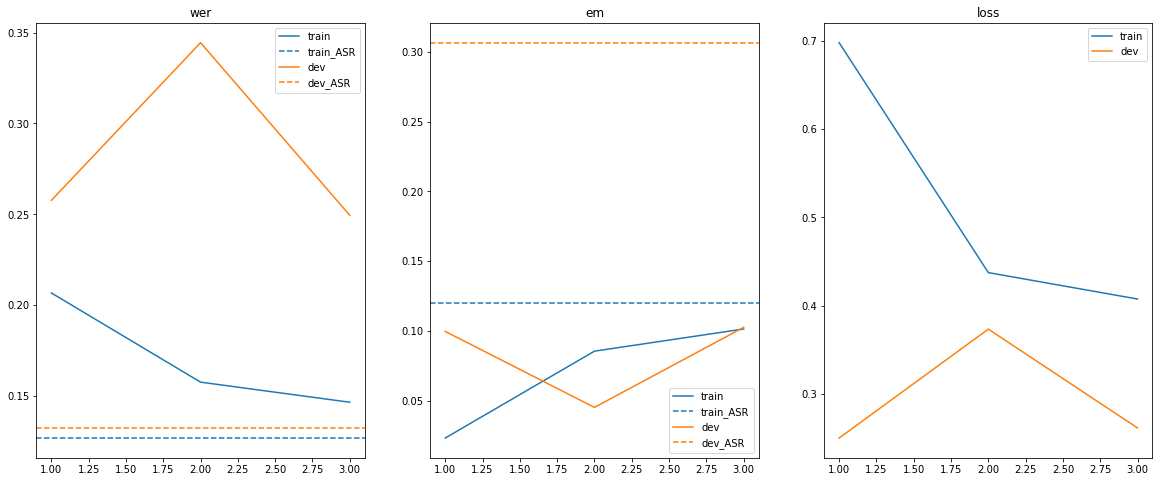

In [17]:
if debug:
    plot_graphs(debub_metrics_df, gt_df=asr_evaluator.metrics_df, fig_size=(20,8))

## Model REC-ACE

In [ ]:
assert debug==False, "You are in debug mode, please change to False"

rec_ace_model = RecACEWrapModel(t5_type=t5_type, model_type='rec_ace', bin_size=bin_size, use_pretrained=True).to(DEVICE)
rec_ace_optimizer = torch.optim.Adam(rec_ace_model.parameters(), lr=1e-4)

rec_ace_model, rec_ace_metrics_df = training(
    model=rec_ace_model,
    n_epochs=50,
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer=rec_ace_optimizer,
    exp_name="rec_ace",
    save_model=True)

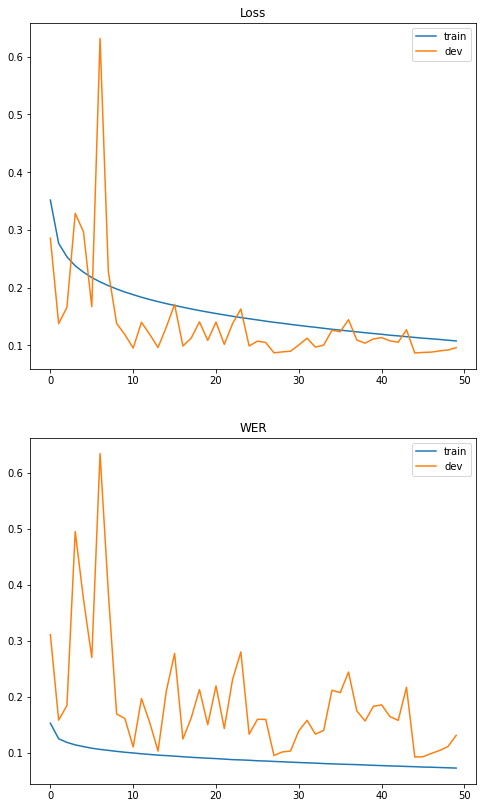

In [16]:
plot_graphs(rec_ace_metrics_df, gt_df=asr_evaluator.metrics_df, fig_size=(20,8))

## Model Original T5

In [ ]:
assert debug==False, "You are in debug mode, please change to False"

orig_model = RecACEWrapModel(t5_type=t5_type, model_type='original', bin_size=bin_size, use_pretrained=True).to(DEVICE)
orig_optimizer = torch.optim.Adam(orig_model.parameters(), lr=1e-4)

orig_model, orig_metrics_df = training(
    model=orig_model,
    n_epochs=50,
    train_data=train_loader,
    dev_data=dev_loader,
    optimizer=orig_optimizer,
    exp_name="original",
    save_model=True)

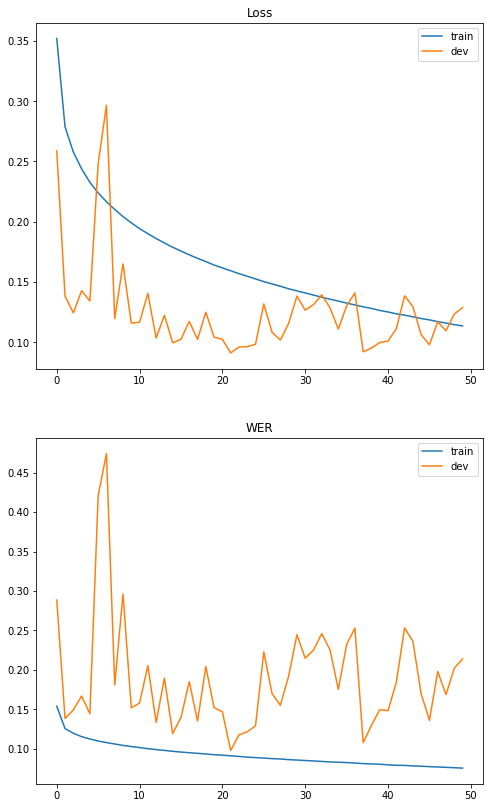

In [12]:
plot_graphs(orig_metrics_df, gt_df=asr_evaluator.metrics_df, fig_size=(20,8))

## Experiments

1. Training the following models:
    1. Calculate WER on Dev on 'Clean' and 'Other'
    1. T5 w/o confidence on 'Clean'
    1. T5 w/ confidence on 'Clean'
    1. T5 w/o confidence on 'Other'
    1. T5 w/ confidence on 'Other'
    *. T5 (large) w/ confidence on 'Clean'
    *. T5 (large) w/o confidence on 'Clean'
    *. Prompt Engineering w/ confidence on 'Clean'
    *. Prompt Engineering w/o confidence on 'Clean'

1. Evaluate performance on Test Dataset
    1. Calculate WER on Test set on 'Clean' and 'Other'
    1. for every BEST model above calculate WER on 'Clean' and 'Other'